In [1]:
Z_DIM = 10

### 1. Load Colored MNIST dataset

In [2]:
import numpy as np
from PIL import Image, ImageColor
from pathlib import Path

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch import tensor
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.utils as vutils

import torch.distributions.constraints as constraints
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='Set2')
import time

import pandas as pd
from tqdm import tqdm

from IPython.display import clear_output

!pip install -q torchsummary
from torchsummary import summary

!pip install -q pyro-ppl
import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, SGD
from pyro.infer import TraceEnum_ELBO, config_enumerate, infer_discrete
pyro.set_rng_seed(0)
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)

from matplotlib.gridspec import GridSpec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 47.0 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
colors = [
        'darkgreen', '#6495ed', 'darkblue', '#b03060',
        'orangered', 'yellow', 'burlywood', 'lime',
        'aqua', 'fuchsia',
    ]
color_names = ['darkgreen', 'blue', 'darkblue', 'maroon', 'orangered',
            'yellow', 'burlywood', 'lime', 'aqua', 'fuchsia']
color_dict = {k: v for k, v in enumerate(color_names)}

def get_rgb(x):
    t = torch.tensor(ImageColor.getcolor(x, "RGB")) / 255.
    return t.view(-1, 1, 1)

NUM_COLORS = len(colors)
colors = list(map(get_rgb, colors))
COUNTERFACTUAL_LABELS = [0,2,4,6,8]

class DoubleColoredMNIST(Dataset):
    def __init__(self, train=True, counterfactual=False):
        self.train = train
        self.counterfactual = counterfactual
        self.mnist_sz = 28

        # get mnist
        if train:
            mnist = datasets.MNIST(root='data', download=True, train=True)
        else:
            mnist = datasets.MNIST(root='data', download=True, train=False)
        ims, labels = mnist.data, mnist.targets
        # self.T = transforms.Compose([
            # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        # ])
        if self.counterfactual:
            self.ims_digit = []
            self.labels = []
            for im, l in zip(torch.stack([ims, ims, ims], dim=1), labels):
                if l.item() in COUNTERFACTUAL_LABELS:
                    self.ims_digit.append(im)
                    self.labels.append(l)
            self.labels = np.array(self.labels)
        else:
            self.ims_digit = torch.stack([ims, ims, ims], dim=1)
            self.labels = labels

    def __getitem__(self, idx):
        digit = self.labels[idx]
        if self.train:
            if digit.item() in COUNTERFACTUAL_LABELS:
                fg_i = np.random.choice([i for i in range(NUM_COLORS) if i != digit])
                bg_i = np.random.choice([i for i in range(NUM_COLORS) if i not in [digit, (digit + 1) % NUM_COLORS, fg_i]])
            else:
                fg_i = np.random.choice(NUM_COLORS)
                bg_i = np.random.choice([i for i in range(NUM_COLORS) if i != fg_i])
        elif self.counterfactual:
            fg_i = int(digit)
            bg_i = int((digit + 1) % NUM_COLORS)
        else:
            fg_i = np.random.choice(NUM_COLORS)
            bg_i = np.random.choice([i for i in range(NUM_COLORS) if i != fg_i])
        back_color = colors[bg_i].clone()
        back_color += torch.normal(0, 1e-3, (3, 1, 1))
        obj_color = colors[fg_i].clone()
        obj_color += torch.normal(0, 1e-3, (3, 1, 1))

        # get digit
        im_digit = (self.ims_digit[idx] / 255.).to(torch.float32)
        im_digit = F.interpolate(im_digit[None,:], (self.mnist_sz, self.mnist_sz)).squeeze()
        im_digit = (im_digit > 0.1).to(int)  # binarize

        # plot digit onto the texture
        ims = im_digit * (obj_color) + (1 - im_digit) * back_color

        ret = {
            # 'img': self.T(ims),
            'img': ims,
            'label': np.array([digit, fg_i, bg_i], dtype=int),
        }
        return ret

    def __len__(self):
        return self.labels.shape[0]

In [5]:
LABEL_SIZES = [10, NUM_COLORS, NUM_COLORS]
LABEL_NAMES = ['digit', 'obj_color', 'bg_color']
dataset_train = DoubleColoredMNIST(train=True)
dataset_test = DoubleColoredMNIST(train=False)
dataset_counterfactual = DoubleColoredMNIST(train=False, counterfactual=True)
print(len(dataset_train), len(dataset_test), len(dataset_counterfactual))

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4451941.51it/s] 


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1100843.28it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9393643.29it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5958876.69it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



60000 10000 4926


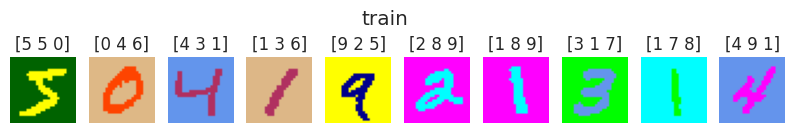

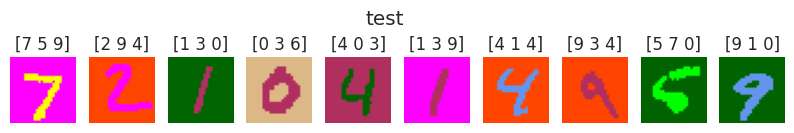

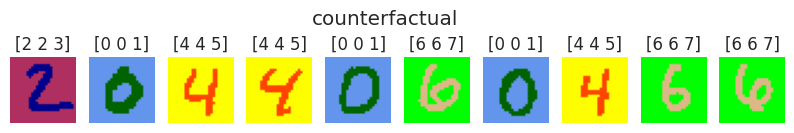

In [6]:
def normalize(img):
    # a = np.expand_dims([0.5, 0.5, 0.5], (0,1))
    normalized = img #* a + a
    return normalized.clip(0, 1)

for n, dataset in zip(['train', 'test', 'counterfactual'], [dataset_train, dataset_test, dataset_counterfactual]):
    plt.figure(figsize=(10, 2))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        sample = dataset[i]
        plt.imshow(normalize(sample['img'].permute(1, 2, 0)))
        plt.title(str(sample['label']))
        plt.axis('off')
    plt.suptitle(n, y=.9)
    plt.show()

In [7]:
BATCH_SIZE = 256
train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)
cf_loader = DataLoader(dataset_counterfactual, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)

### 2. CVAEGAN

In [8]:
def weights_init(model):
    ''' Инициализация весов генератора и дискриминатора '''

    classname = model.__class__.__name__

    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)

    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(self.shape)

def get_one_hot(labels):
    new_ys = []
    for i, label_length in enumerate(LABEL_SIZES):
        new_y = nn.functional.one_hot(labels[:, i].to(torch.int64), int(label_length))
        new_ys.append(new_y)
    new_ys = torch.cat(new_ys, -1)
    return new_ys.to(torch.float32)

In [13]:
class Decoder(nn.Module):
    def __init__(self, z_dim=Z_DIM, label_dim=30, p=0.1):
        super(Decoder, self).__init__()
        self.label_dim = label_dim
        self.layers = nn.Sequential(
            nn.Linear(z_dim+label_dim, 128*7*7),
            Reshape((-1, 128, 7, 7)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Dropout(p),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.Upsample((14, 14)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.Upsample((28, 28)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 3, 3, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, z, labels):
        data = torch.cat([z, get_one_hot(labels)], dim=1)
        prob_output = self.layers(data)
        return prob_output

class Encoder(nn.Module):
    def __init__(self, z_dim=Z_DIM, label_dim=30, p=0.1):
        super(Encoder, self).__init__()
        self.label_dim = label_dim
        self.layers = nn.Sequential(
            nn.Conv2d(3+label_dim, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Dropout(p)
        )
        self.fc_output_loc = nn.Linear(2304, z_dim)
        self.fc_output_scale = nn.Linear(2304, z_dim)

    def forward(self, x, labels):
        labels = get_one_hot(labels).T
        labels = labels.expand([28, 28, self.label_dim, labels.size(1)]).T
        data = torch.cat([x, labels], dim=1)  # (BS, 33, 28, 28)
        hidden = self.layers(data)
        z_loc = self.fc_output_loc(hidden)
        z_scale = torch.exp(self.fc_output_scale(hidden))
        return z_loc, z_scale

class Discriminator(nn.Module):
    def __init__(self, label_dim=30, p=0.3):
        super(Discriminator, self).__init__()
        self.label_dim = label_dim
        self.layers = nn.Sequential(
            nn.Conv2d(3+label_dim, 128, 5, 2, 1),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Dropout(p),
            nn.Linear(2304, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        labels = get_one_hot(labels).T
        labels = labels.expand([28, 28, self.label_dim, labels.size(1)]).T
        data = torch.cat([x, labels], dim=1)  # (BS, 33, 28, 28)
        return self.layers(data)

In [14]:
class CVAE_GAN(nn.Module):
    def __init__(self, z_dim=Z_DIM, label_dim=30, p=0.2, use_cuda=False):
        super().__init__()
        self.encoder_ = Encoder(z_dim, label_dim=label_dim, p=p)
        self.decoder_ = Decoder(z_dim, label_dim=label_dim, p=p)
        self.discriminator_ = Discriminator(label_dim, p=p)
        if use_cuda:
            self.cuda()
        self.device = 'cuda' if use_cuda else 'cpu'
        self.use_cuda = use_cuda
        self.z_dim = z_dim
        self.label_dim = label_dim

    def model(self, x, labels):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        self.discriminator_.train(False)
        pyro.module("decoder", self.decoder_)

        with pyro.plate("data", x.shape[0]):
            # pior for Z
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

            # decode img using z
            loc_img = self.decoder_(z, labels)
            pyro.sample("obs", dist.Bernoulli(loc_img.squeeze()).to_event(3), obs=x.squeeze())

            # is_real part
            prob_real = self.discriminator_(loc_img, labels).squeeze()
            prob_real = prob_real.expand([28*28*3, *prob_real.shape]).T
            ones = torch.full((x.shape[0],), 1., dtype=torch.float, device=self.device)
            ones = ones.expand([28*28*3, *ones.shape]).T
            pyro.sample("is_real", dist.Bernoulli(prob_real).to_event(1), obs=ones)

    def guide(self, x, labels):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        pyro.module("encoder", self.encoder_)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder_(x, labels)
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def model_generate(self, batch_size):
        self.discriminator_.train(False)
        pyro.module("decoder", self.decoder_)
        with pyro.plate("data", batch_size):
            # pior for Z
            z_loc = torch.zeros(torch.Size((batch_size, self.z_dim)), dtype=torch.float, device=self.device)
            z_scale = torch.ones(torch.Size((batch_size, self.z_dim)), dtype=torch.float, device=self.device)
            z = dist.Normal(z_loc, z_scale).rsample()

            # random labels for generation
            rand_labels = torch.randint(low=0, high=10, size=(batch_size, 3), device=self.device)
            loc_img = self.decoder_(z, rand_labels)
            prob_real = self.discriminator_(loc_img, rand_labels).squeeze()
            ones = torch.full((batch_size,), 1., dtype=torch.float, device=self.device)
            pyro.sample("obs", dist.Bernoulli(prob_real), obs=ones)

    def guide_generate(self, batch_size):
        pass

    def encoder(self, x, labels, return_cpu=True):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        z_loc, z_scale = self.encoder_(x, labels)
        if self.use_cuda and return_cpu:
            z_loc = z_loc.cpu()
            z_scale = z_scale.cpu()
        return z_loc, z_scale

    def decoder(self, z, labels, return_cpu=True):
        if self.use_cuda:
            z = z.cuda()
            labels = labels.cuda()
        loc_img = self.decoder_(z, labels)
        if self.use_cuda and return_cpu:
            loc_img = loc_img.cpu()
        return loc_img

    def reconstruct_img(self, x, labels, return_cpu=True):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        z_loc, z_scale = self.encoder_(x, labels)
        z = dist.Normal(z_loc, z_scale).sample()
        loc_img = self.decoder_(z, labels)
        if self.use_cuda and return_cpu:
            loc_img = loc_img.cpu()
        return loc_img

### 3. Inference (973 epochs, all combs)

In [15]:
pyro.clear_param_store()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = CVAE_GAN(p=0.2, use_cuda=torch.cuda.is_available())
vae.load_state_dict(torch.load('/content/vaegan_zdim10.pt', map_location='cpu'))

<All keys matched successfully>

#### Clouds


<ipython-input-13-fa332a19f2ee>:72: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3675.)
  labels = labels.expand([28, 28, self.label_dim, labels.size(1)]).T


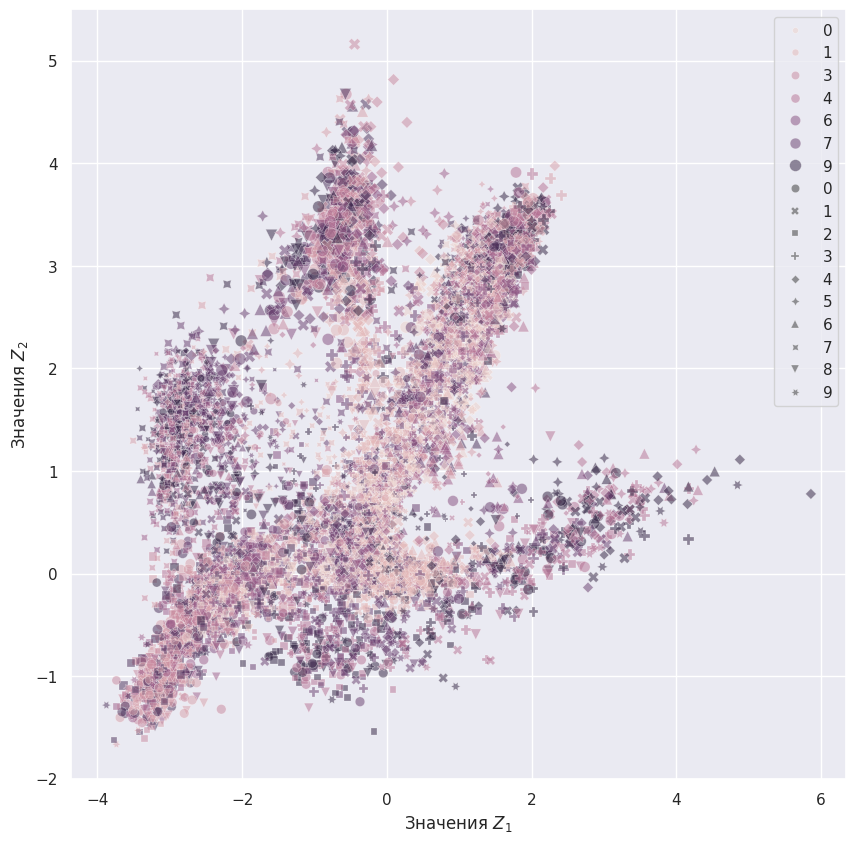

In [16]:
labels = []
z_all = []
for batch in test_loader:
    x = batch['img']
    l = batch['label']
    labels.append(l.detach().numpy())
    z = vae.encoder(x, l)[0].detach().numpy()
    z_all.append(z)

labels = np.concatenate(labels)
z_all = np.vstack(z_all)

plt.figure(figsize=(10, 10))
sns.scatterplot(x=z_all[:, 0], y=z_all[:, 1], hue=labels[:,0],
                style=labels[:,1], size=labels[:,2], alpha=0.5)
plt.xlabel('Значения $Z_1$')
plt.ylabel('Значения $Z_2$');

In [17]:
from scipy.special import expit
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [22]:
def to_alpha(img):
    img = np.concatenate([np.array(img), 0.5 * np.ones(shape=(1, *img.shape[1:]))])
    return img.transpose((1, 2, 0))

def create_data_image(
    vae,
    data_loader,
    ymin=-4,
    ymax=4,
    do_expit=False,
    max_pictures=None,
    figsize=(20, 20),
    zoom=0.6,
    fname=None,
    dpi=200,
    axis=False,
    xlabel='',
    ylabel='',
    title=''
):

    with sns.axes_style('whitegrid' if axis else 'white'):
        fig, ax = plt.subplots(figsize=figsize)
        n_pictures = 0

        for i, batch in enumerate(data_loader):
            x, l = batch['img'], batch['label']
            y = vae.encoder(x, l)[0].detach().numpy()
            if do_expit:
                y = expit(y)

            for i in range(len(x)):
                img = to_alpha(x[i].detach().numpy())
                imagebox = OffsetImage(normalize(img), zoom=zoom)
                ab = AnnotationBbox(imagebox, (y[i, 0], y[i, 1]), frameon=False)
                ax.add_artist(ab)
            if i > 30:
                break

        plt.xlim((ymin, ymax))
        plt.ylim((ymin, ymax))
        if not axis:
            plt.axis('off')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.tight_layout()

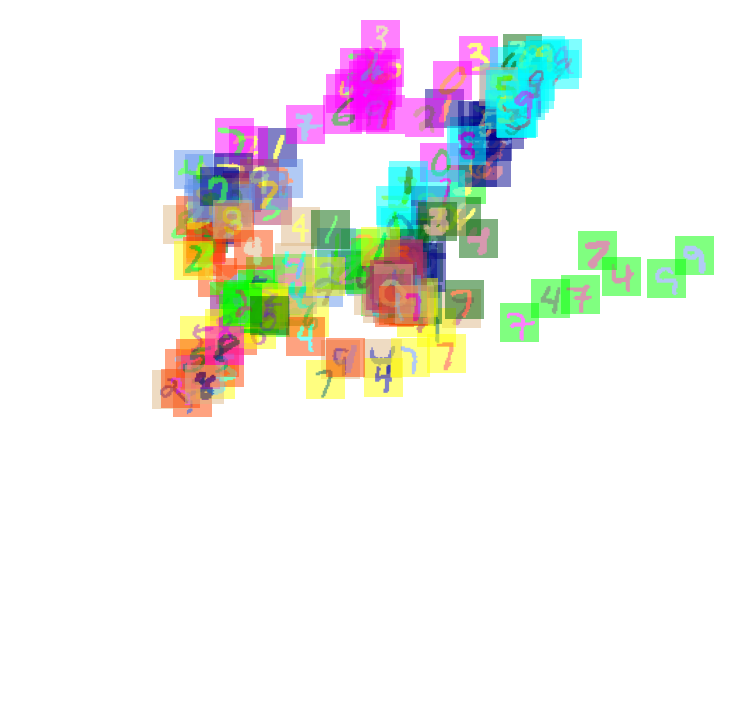

In [24]:
create_data_image(vae, test_loader, figsize=(7, 7), zoom=1)

### 4. Other versions

In [ ]:
!mkdir models
!unzip -q /content/zdim10_models.zip -d models
import os
paths = os.listdir('/content/models')
paths = paths[:2] + [paths[-1]] + paths[2:4]

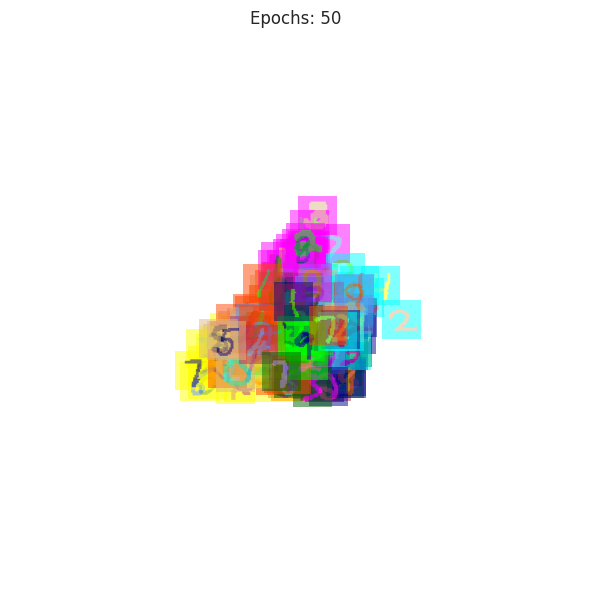

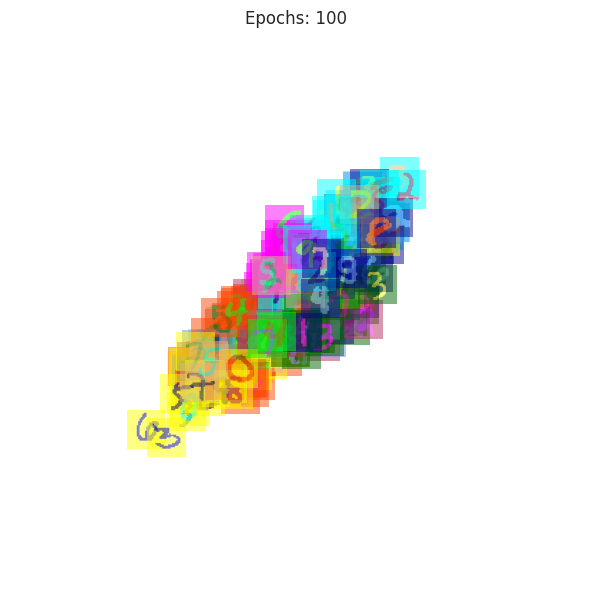

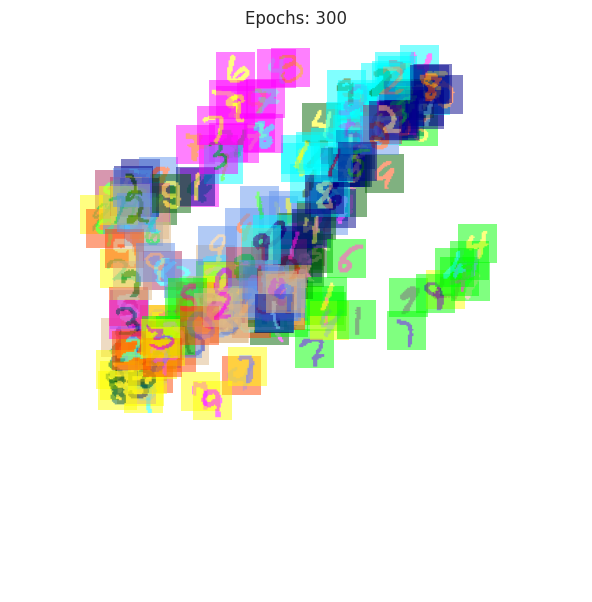

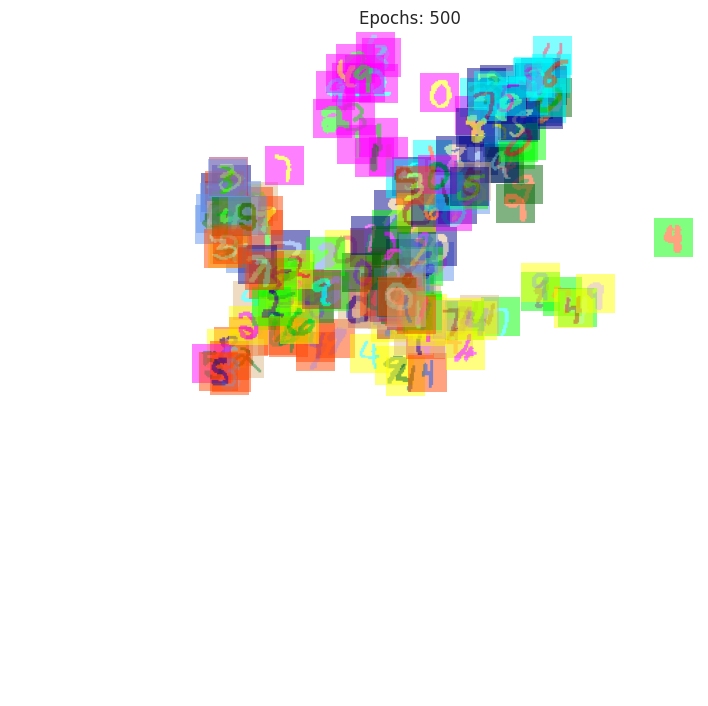

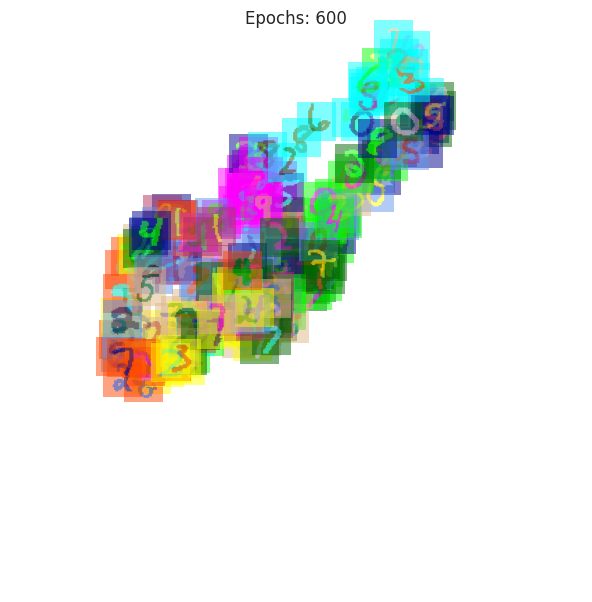

In [33]:
root = '/content/models'
for f, epochs in zip(os.listdir(root), [50, 100, 300, 500, 600]):
    pyro.clear_param_store()
    vae = CVAE_GAN(p=0.2, use_cuda=torch.cuda.is_available())
    vae.load_state_dict(torch.load(root+'/'+f, map_location='cpu'))
    create_data_image(vae, test_loader, figsize=(7, 7), zoom=1, title="Epochs: "+str(epochs))